# Neighborlist Feature Generators <a name="head"></a>

In this tutorial, we will look at generating features from a database of organic donor-acceptor molecules from the [Computational Materials Repository](https://cmrdb.fysik.dtu.dk/?project=solar). This has been downloaded in the [ase-db](https://wiki.fysik.dtu.dk/ase/ase/db/db.html#module-ase.db) format so first off we load the atoms objects and get a target property. Then we convert the atoms objects into a feature array and test out a couple of different models.

This tutorial will give an indication of one way in which it is possible to handle atoms objects of different sizes. In particular, we focus on a feature set that scales with the number of atoms. We pad the feature vectors to a constant size to overcome this problem.

In [1]:
# Comment out this line when exported to .py file
%matplotlib inline

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns

import ase.db

from catlearn.featurize.setup import FeatureGenerator
from catlearn.regression import RidgeRegression, GaussianProcess
from catlearn.cross_validation import Hierarchy
from catlearn.regression.cost_function import get_error

We have stored our atomic structures in an ASE database file. Therefore, we first need to import it and put it in a list of atoms objects.

In [2]:
# Connect the ase-db.
db = ase.db.connect('../../data/solar.db')
atoms = list(db.select())
random.shuffle(atoms)

# Compile a list of atoms and target values.
alist = []
targets = []
for row in atoms:
    try:
        targets.append(row.Energy)
        alist.append(row.toatoms())
    except AttributeError:
        continue
print('pulled {} molecules from db'.format(len(alist)))

pulled 5419 molecules from db


In [3]:
# Analyze the size of molecules in the db.
size = []
for a in alist:
    size.append(len(a))

print('min: {0}, mean: {1:.0f}, max: {2} molecule size'.format(
    min(size), sum(size)/len(size), max(size)))

min: 26, mean: 87, max: 294 molecule size


In [4]:
# Divide up the data into a test and training set.
train_size = 1000
train_atoms = alist[:train_size]
test_atoms = alist[train_size:]
train_targets = np.asarray(targets[:train_size])
test_targets = np.asarray(targets[train_size:])

print('{} shape training atoms data'.format(
    np.shape(train_atoms)))
print('{} shape testing atoms data'.format(
    np.shape(test_atoms)))

(1000,) shape training atoms data
(4419,) shape testing atoms data


In [5]:
generator = FeatureGenerator(element_parameters=['atomic_number'])

generator.normalize_features(
    train_candidates=train_atoms, test_candidates=test_atoms)
print('Max number of atom present in data: {}'.format(generator.atom_len))
print('Atom numbers present in data: {}'.format(generator.atom_types))

Max number of atom present in data: 294
Atom numbers present in data: [1, 6, 7, 8, 9, 14, 16, 32, 34]


In [6]:
train_features = generator.return_vec(
    train_atoms, [generator.neighbor_sum_vec])

test_features = generator.return_vec(
    test_atoms, [generator.neighbor_sum_vec])

print('{} shape training feature matrix'.format(
    np.shape(train_features)))
print('{} shape testing feature matrix'.format(
    np.shape(test_features)))

100%|██████████| 4419/4419 [00:19<00:00, 229.62it/s]

(1000, 294) shape training feature matrix
(4419, 294) shape testing feature matrix


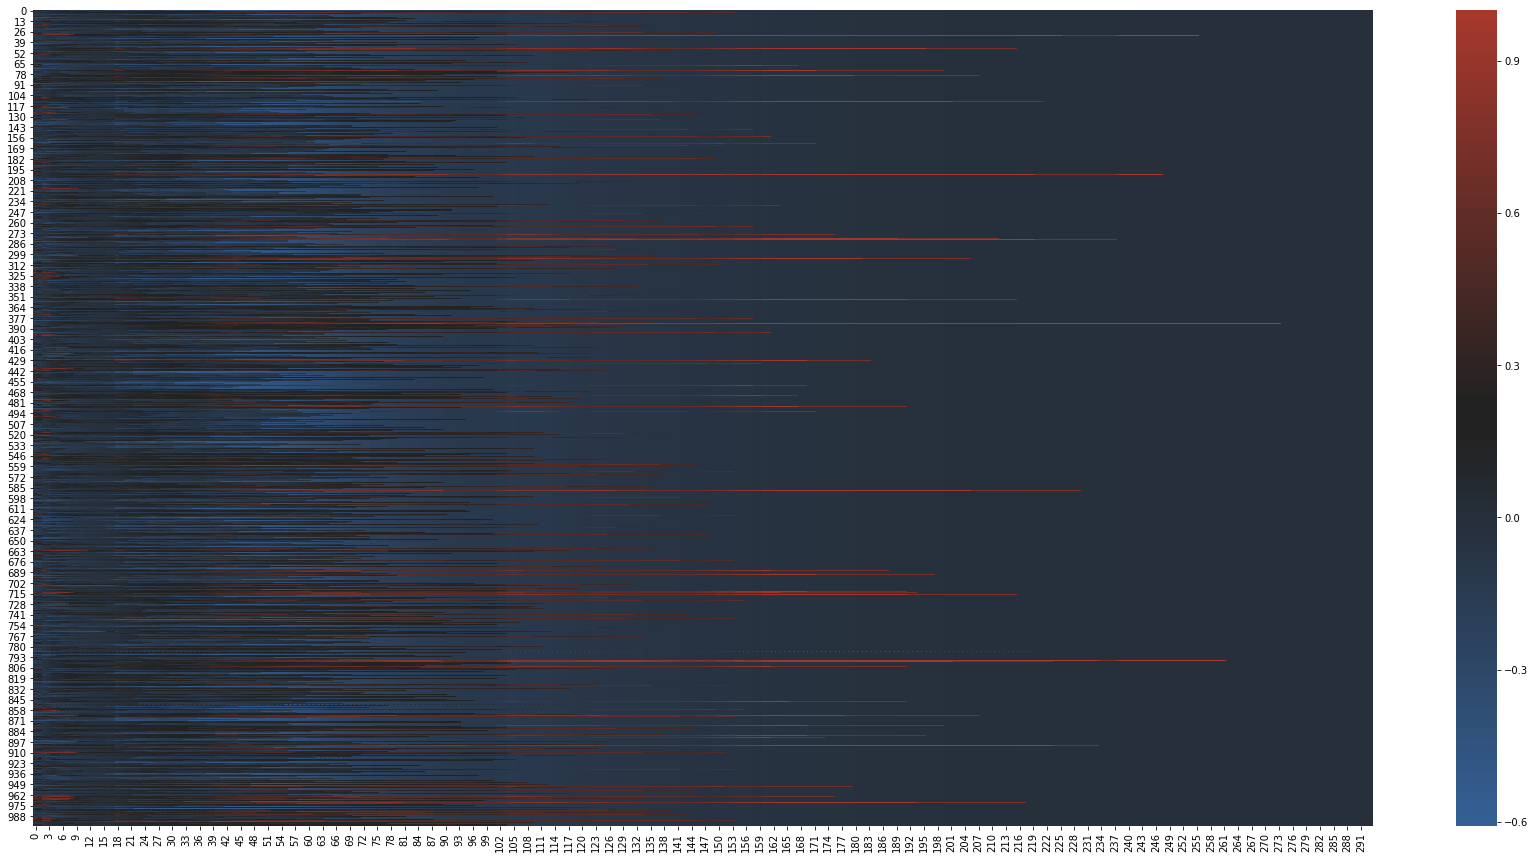

In [7]:
dif = np.max(train_features, axis=0) - np.min(train_features, axis=0)
np.place(dif, dif == 0., [1.])
mean = np.mean(train_features, axis=0)
scaled = (train_features.copy() - mean) / dif
plt.figure(num=0, figsize=(30,15))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=1000, center="dark")
sns.heatmap(scaled, cmap=cmap)

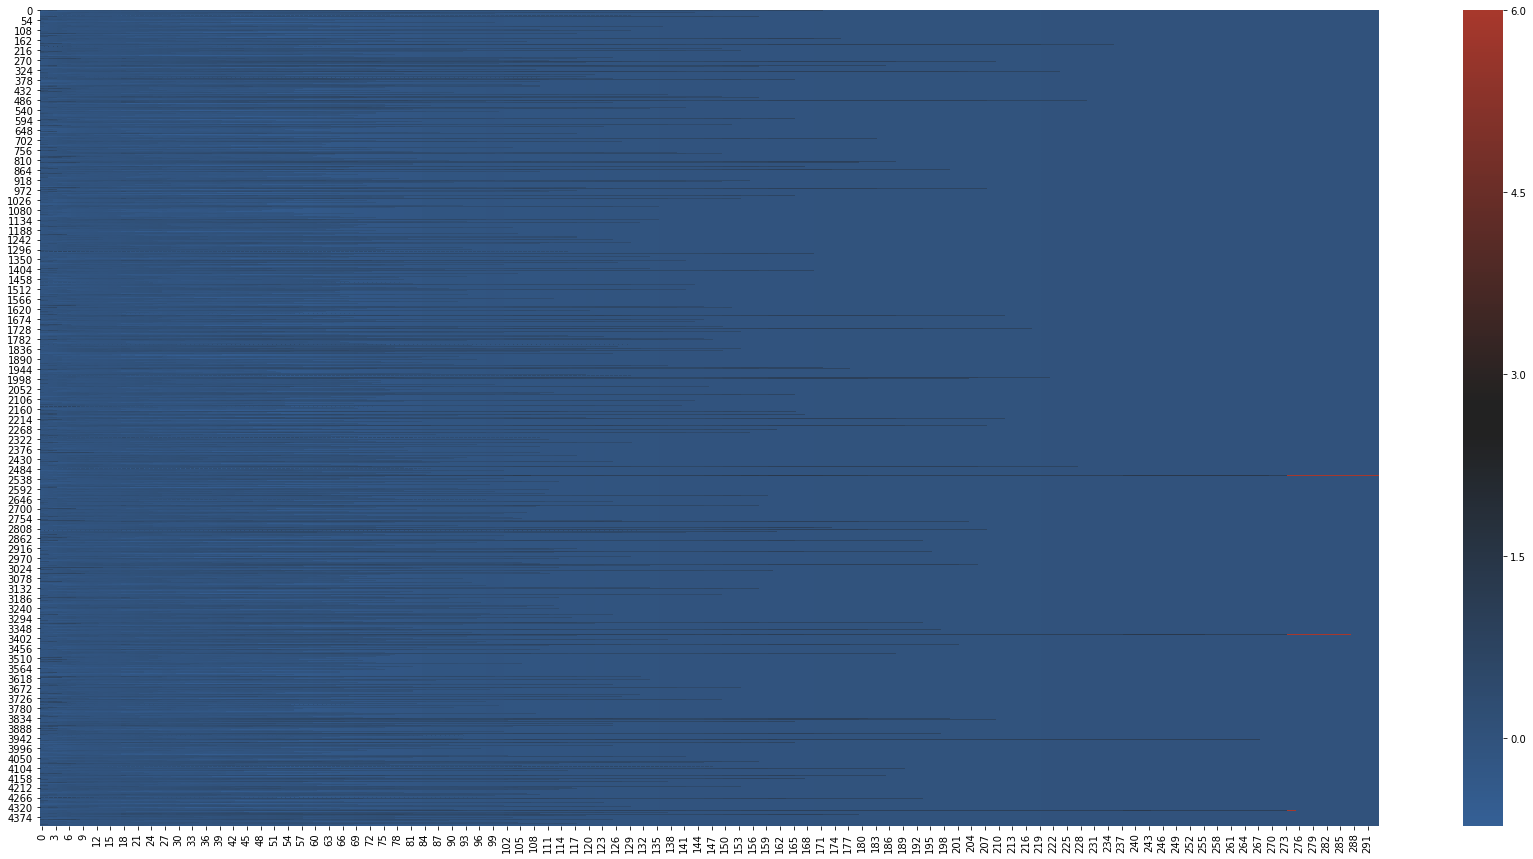

In [8]:
scaled = (test_features.copy() - mean) / dif
plt.figure(num=1, figsize=(30,15))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=1000, center="dark")
sns.heatmap(scaled, cmap=cmap)

In [9]:
tf = train_features.copy()
td = np.reshape(train_targets.copy(), (len(train_targets), 1))
train_data = np.concatenate((tf, td), axis=1)

columns = ['f{}'.format(i) for i in range(np.shape(train_features)[1])]
columns += ['target']
index = range(np.shape(train_features)[0])
df = pd.DataFrame(train_data, index=index, columns=columns)

In [10]:
cmap = cm.get_cmap('Spectral')

def parallel_plot(data, num=None):
    plt.figure(num=num, figsize=(50,25))
    ax = parallel_coordinates(
        data, 'target', colormap=cmap, axvlines=False)

    plt.legend().set_visible(False)
    plt.grid(False)

    ax.xaxis.set_ticks_position('none')
    for label in ax.get_xticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(0)
    for label in ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(30)
    axis_font = {'fontname':'Arial', 'size':'35'}
    plt.ylabel("Numeric Representation", **axis_font)
    plt.xlabel("Fingerprint", **axis_font)

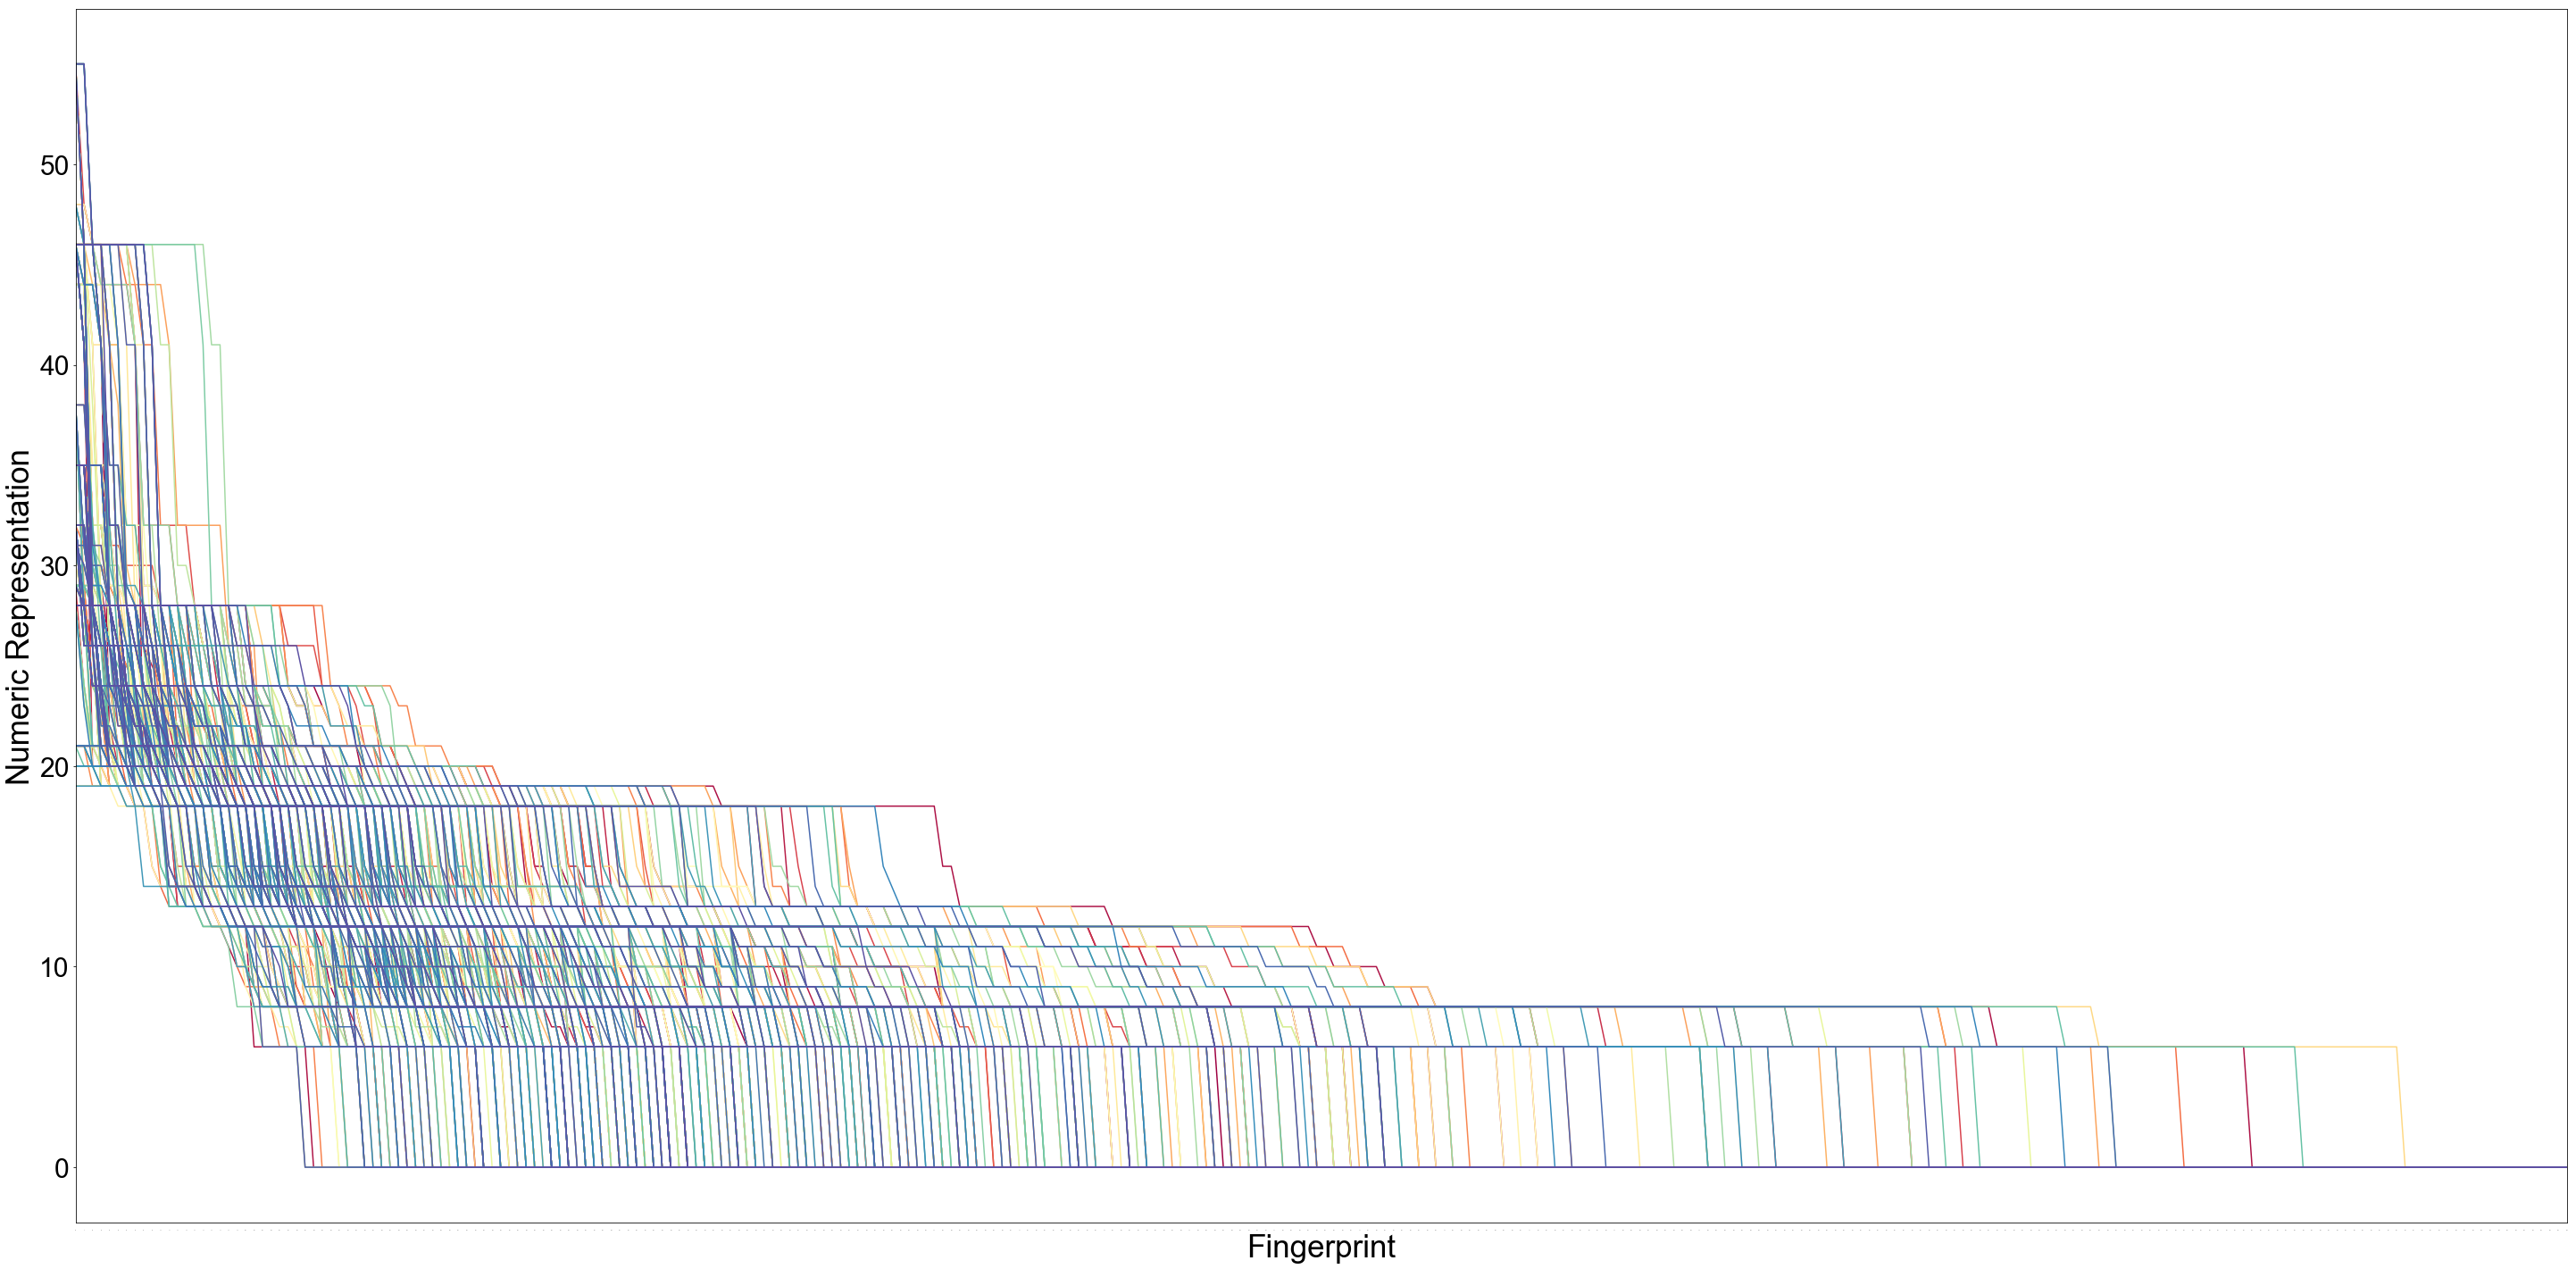

In [11]:
parallel_plot(df, num=2)

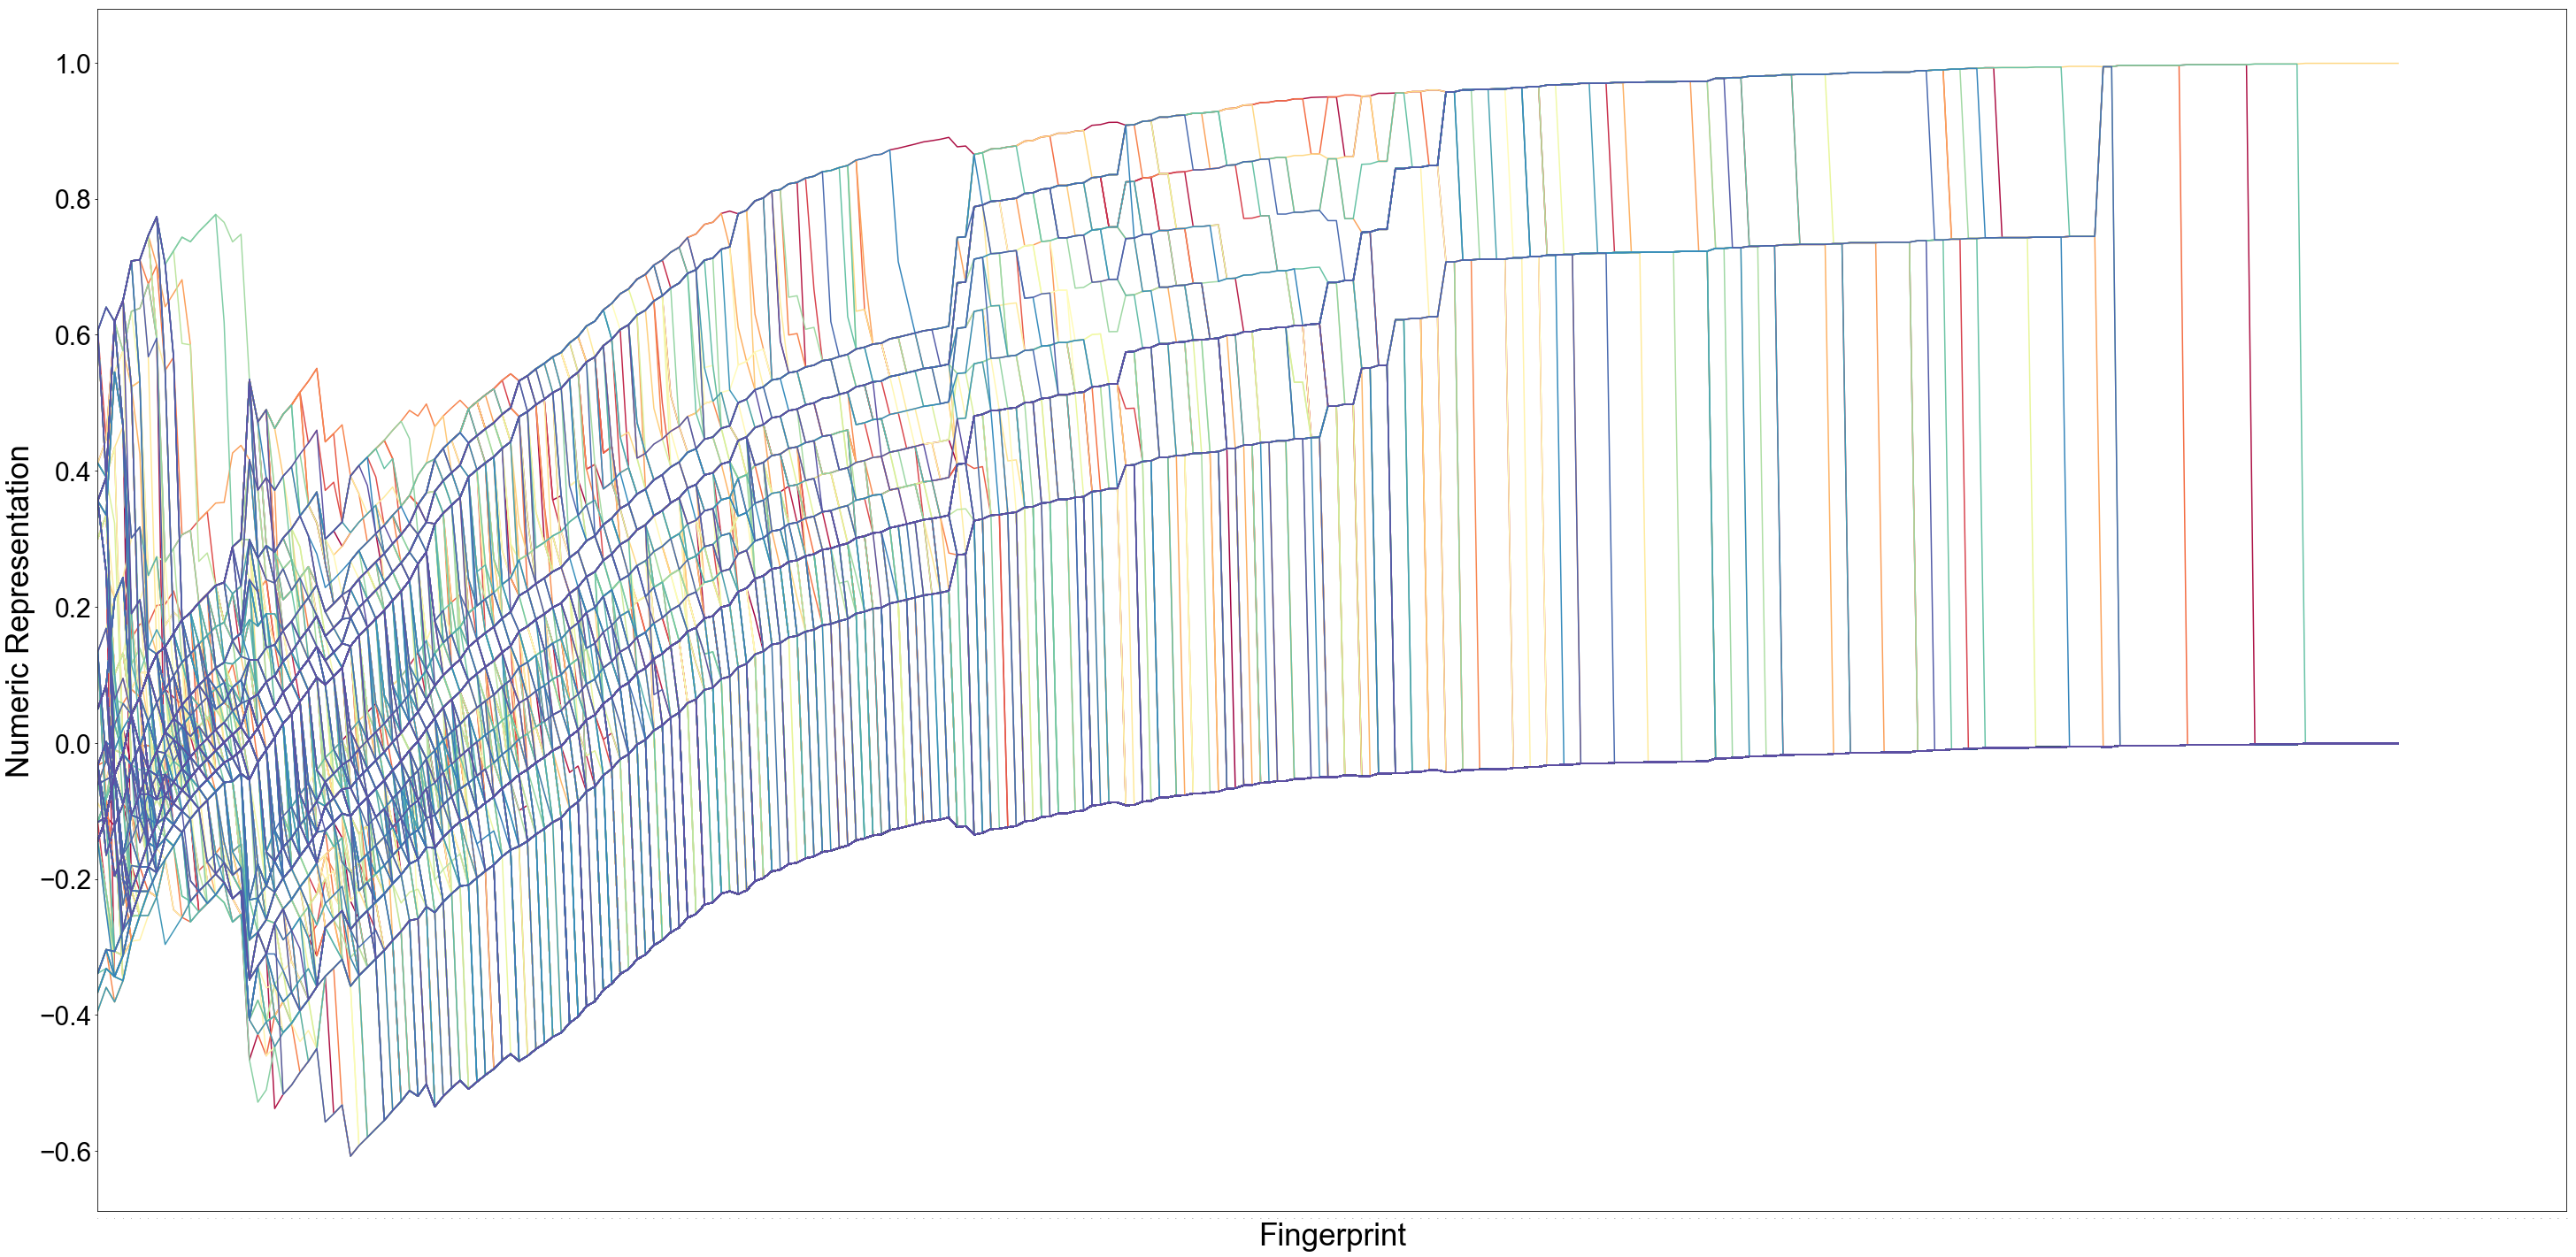

In [12]:
df_norm = (df - df.mean()) / (df.max() - df.min())
df_norm.fillna(0.)
parallel_plot(df_norm, num=3)

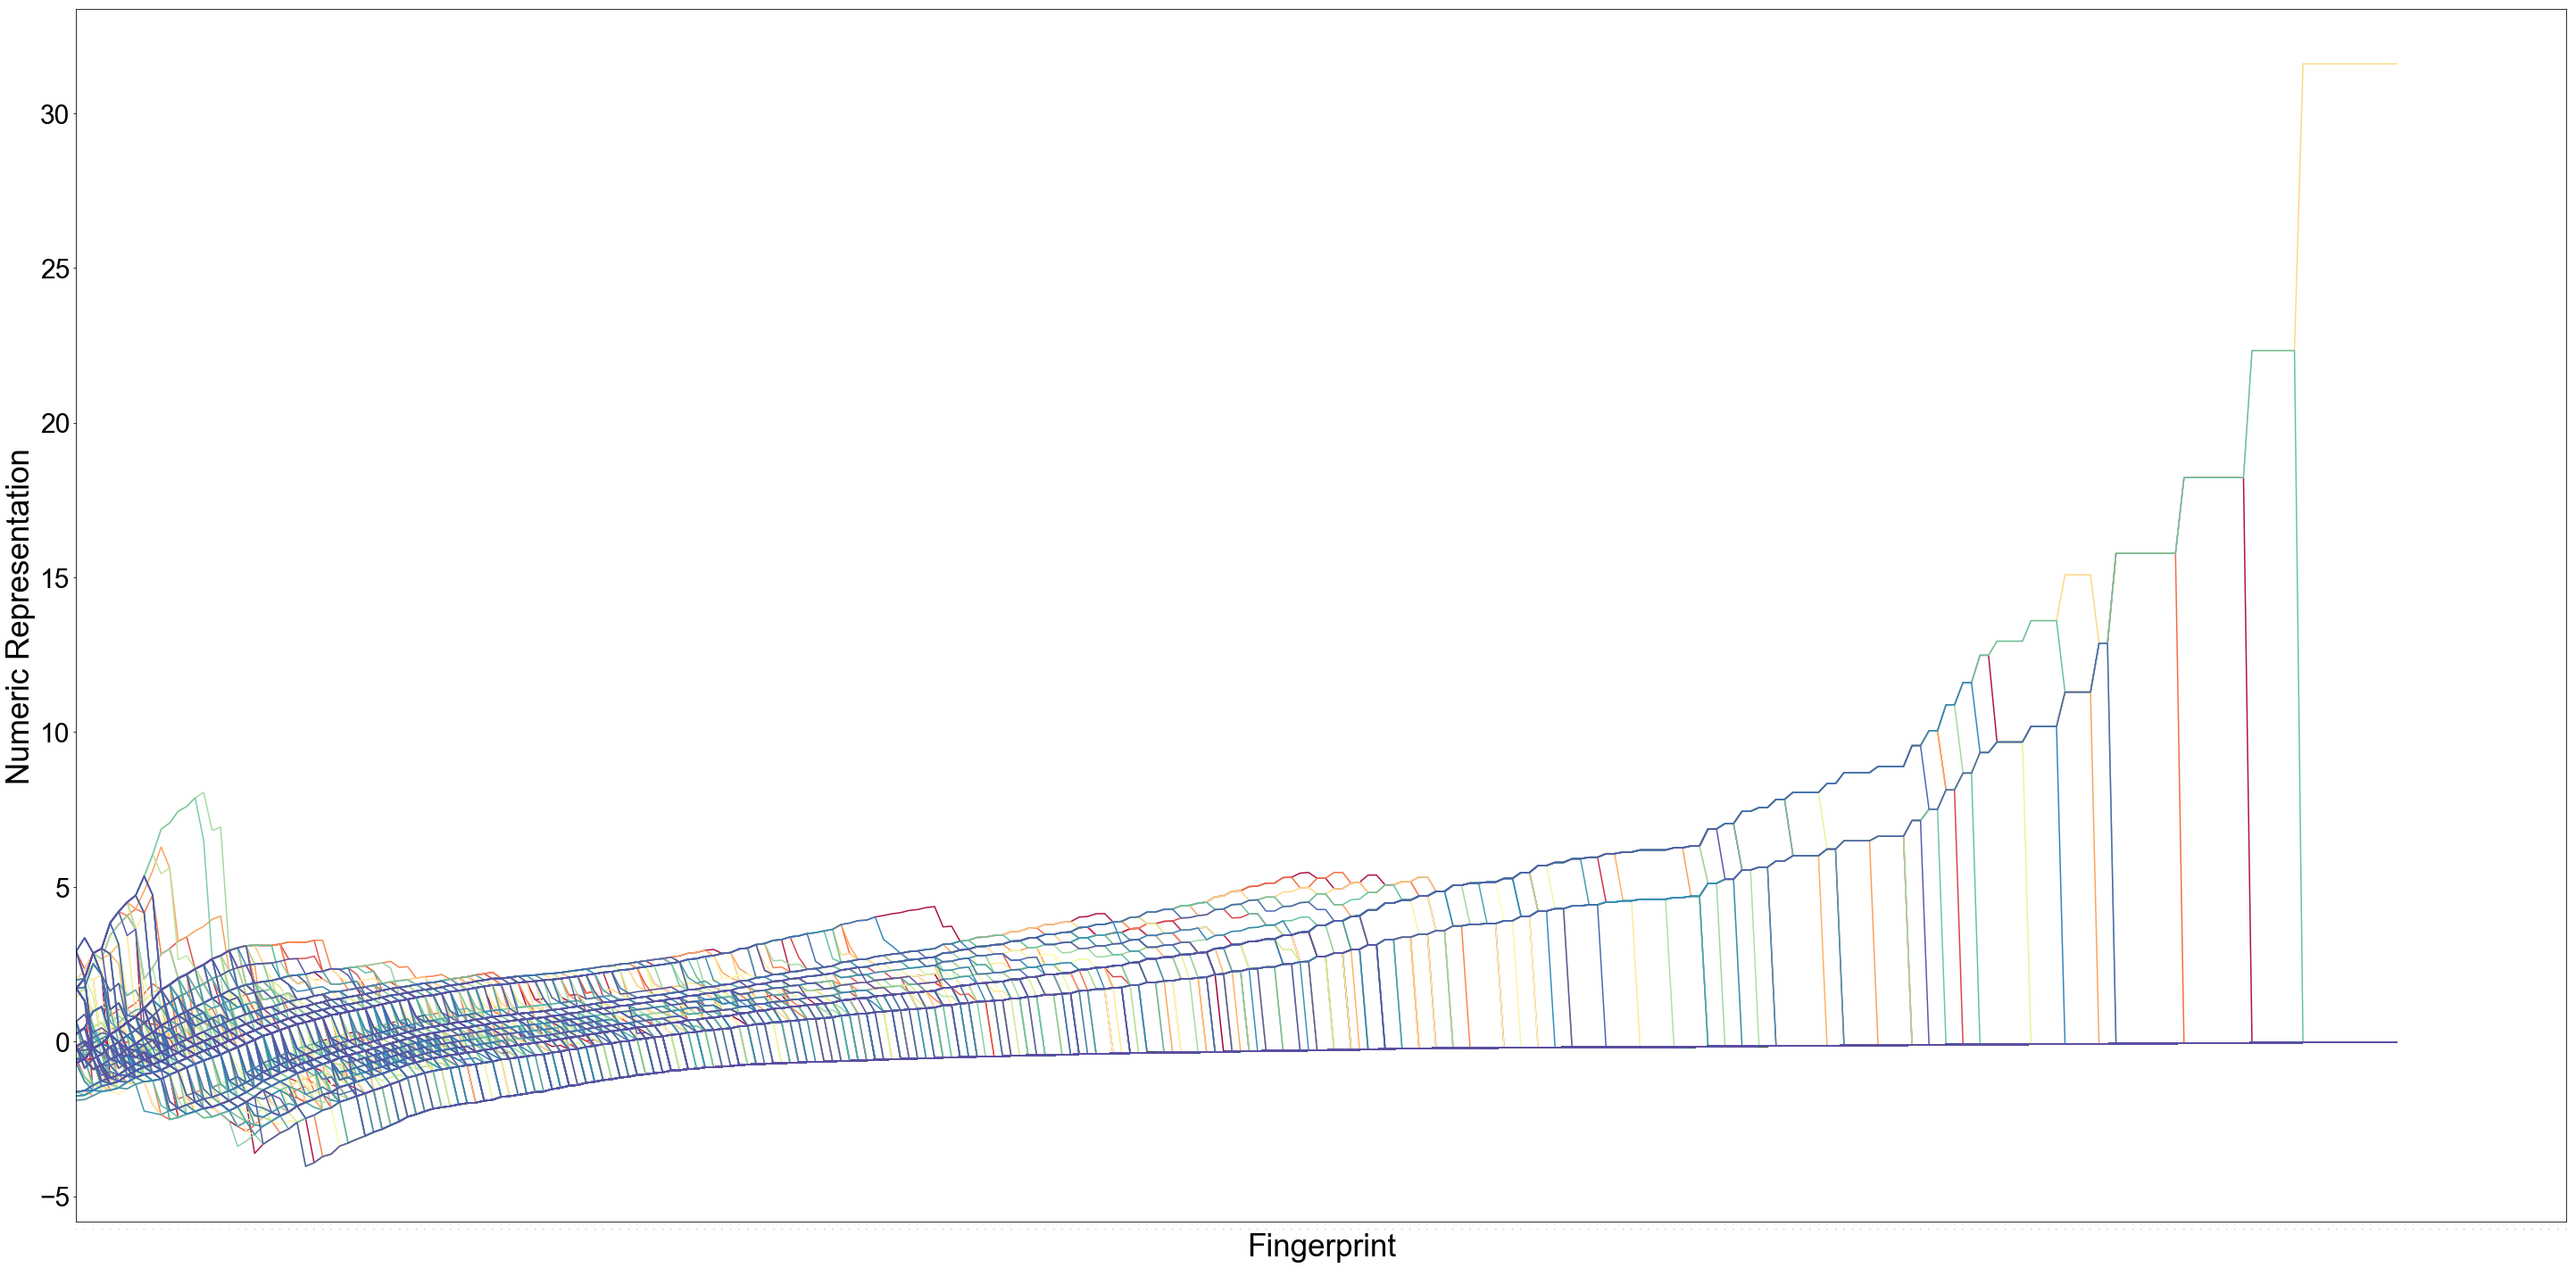

In [13]:
df_std = (df - df.mean()) / df.std()
df_std.fillna(0.)
parallel_plot(df_std, num=4)

/mnt/c/Users/raul_desktop/github/Catlearn/catlearn/regression/ridge_regression.py:433: RuntimeWarning: divide by zero encountered in power
  np.dot(Y_.T, P), np.diag(np.diag(P)**-2)), P), Y_)


112901.81260032875


<Figure size 432x288 with 0 Axes>

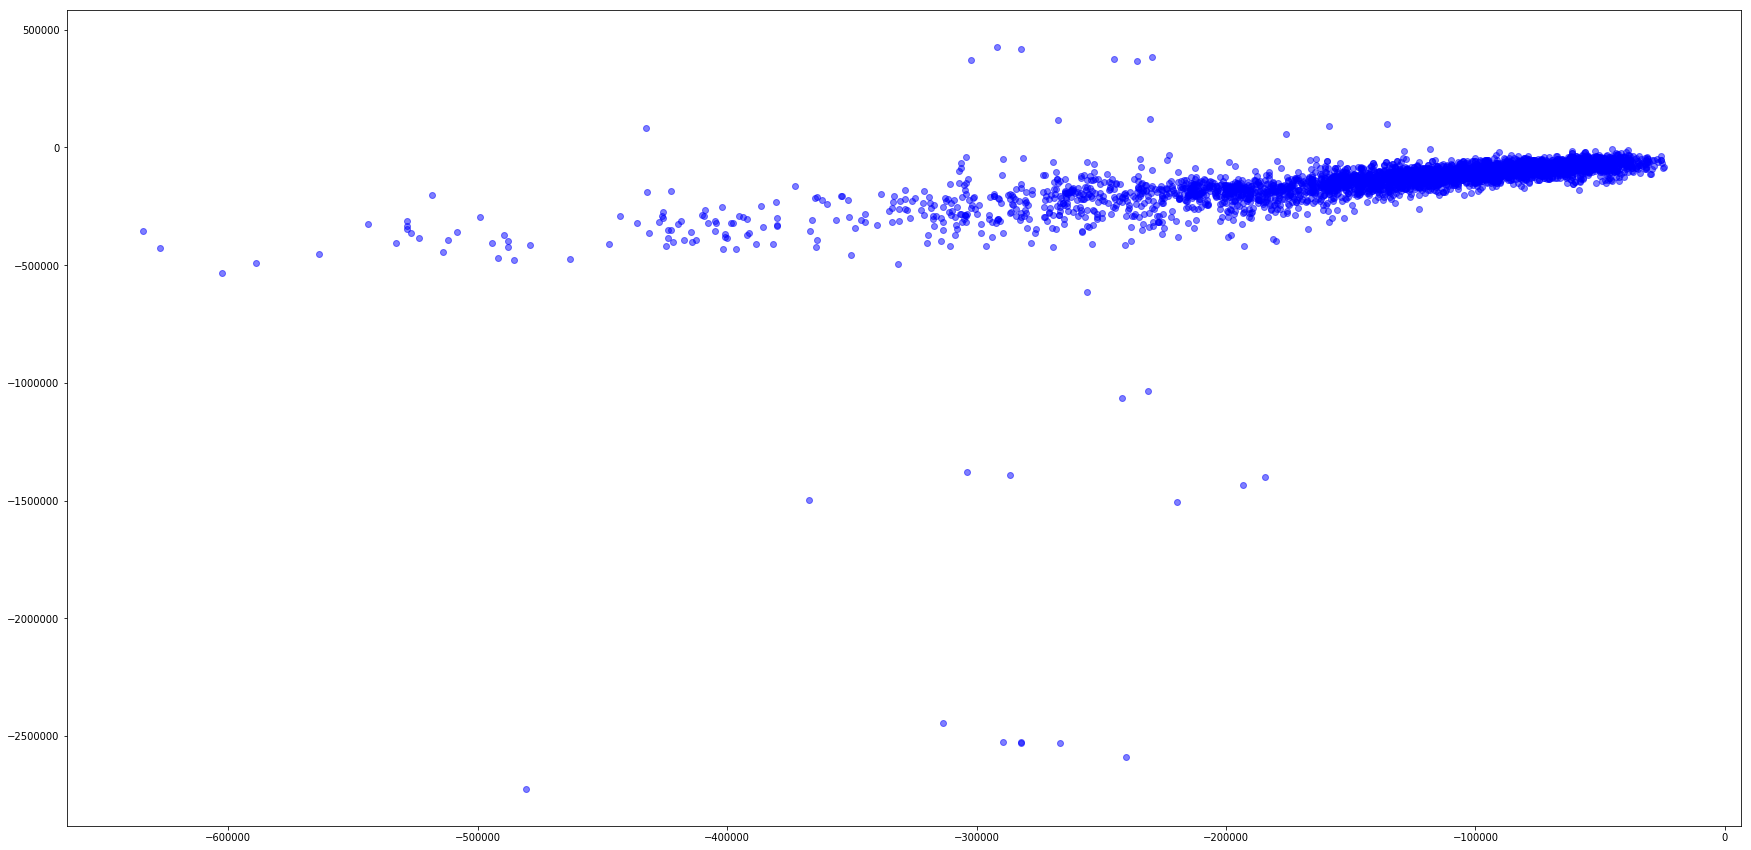

In [14]:
# Set up the ridge regression function.
rr = RidgeRegression(W2=None, Vh=None, cv='loocv')
b = rr.find_optimal_regularization(X=train_features, Y=train_targets)
coef = rr.RR(X=train_features, Y=train_targets, omega2=b)[0]

# Test the model.
sumd = 0.
err = []
pred = []
for tf, tt in zip(test_features, test_targets):
    p = np.dot(coef, tf)
    pred.append(p)
    sumd += (p - tt) ** 2
    e = ((p - tt) ** 2) ** 0.5
    err.append(e)
error = (sumd / len(test_features)) ** 0.5

print(error)
plt.figure(num=5)
plt.figure(figsize=(30, 15))
plt.plot(test_targets, pred, 'o', c='b', alpha=0.5)

25233.32511708635


<Figure size 432x288 with 0 Axes>

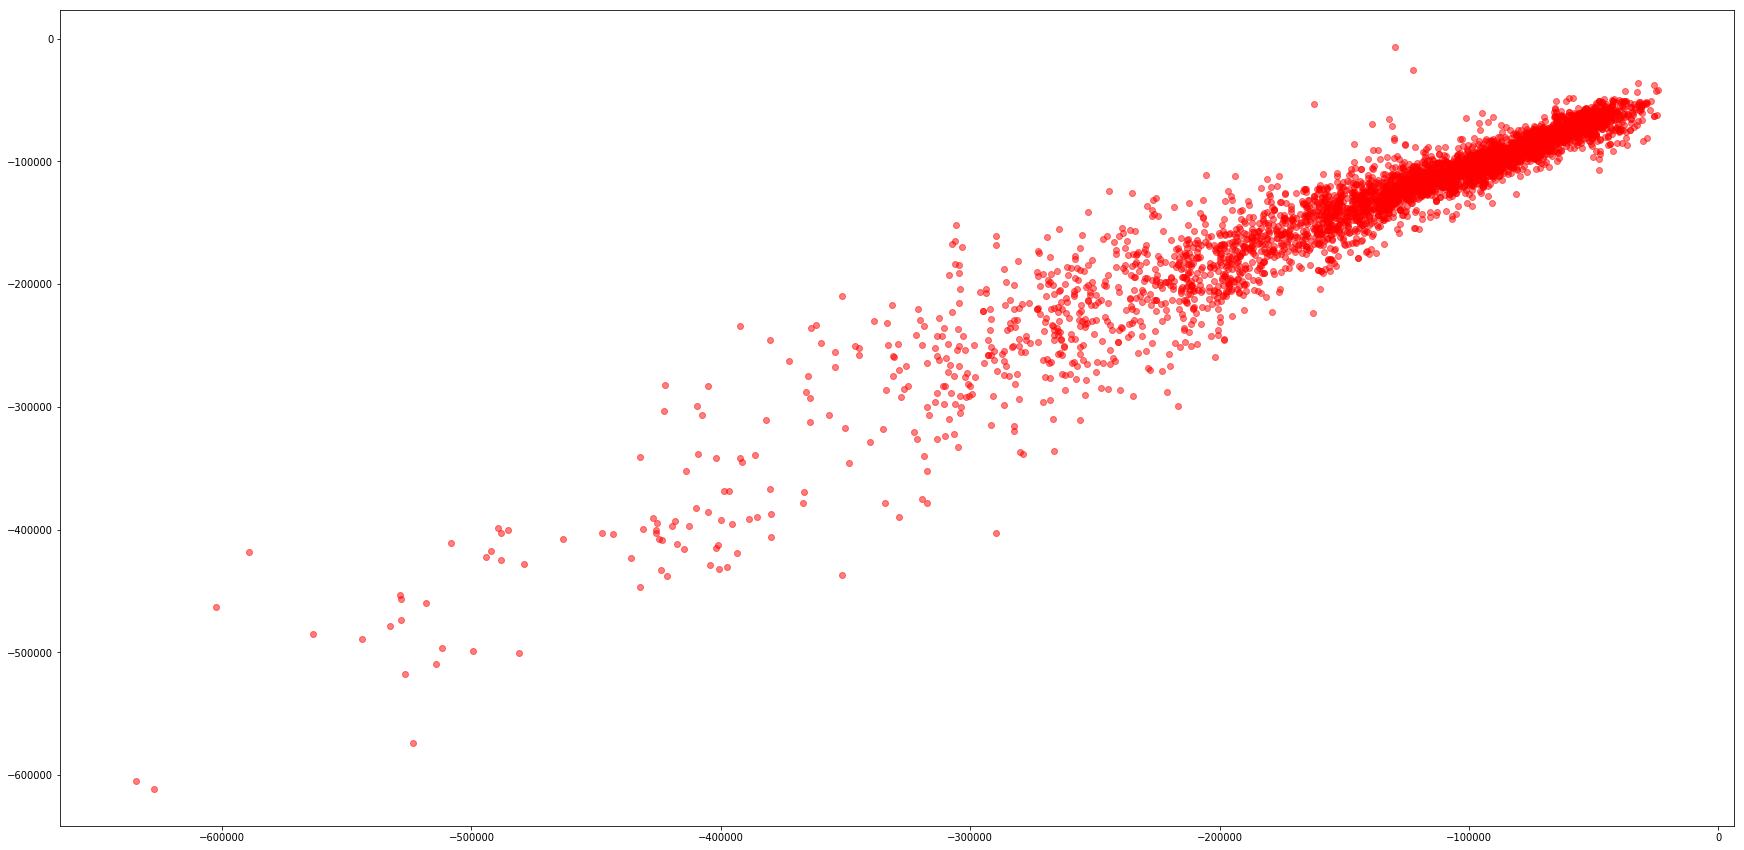

In [15]:
kdict = [
    {
        'type': 'gaussian', 'width': 1., 'scaling': 1., 'dimension': 'single'},
    {
        'type': 'linear', 'scaling': 1.},
    ]
gp = GaussianProcess(train_fp=train_features, train_target=train_targets,
                     kernel_list=kdict, regularization=1e-2,
                     optimize_hyperparameters=True, scale_data=True)

pred = gp.predict(test_fp=test_features)

error = get_error(pred['prediction'],
                  test_targets)['rmse_average']

print(error)
plt.figure(num=6)
plt.figure(figsize=(30, 15))
plt.plot(test_targets, pred['prediction'], 'o', c='r', alpha=0.5)

In [16]:
plt.show()